## 나이브 방법
- 앞의 샘플 값으로 예측

In [1]:
# one-step naive forecast
def naive_forecast(history, n):
  return history[-n]

In [2]:
# define dataset
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
print(data)
# test naive forecast
for i in range(1, len(data)+1):
  print(naive_forecast(data, i))

[10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
100.0
90.0
80.0
70.0
60.0
50.0
40.0
30.0
20.0
10.0


In [5]:
from numpy import mean
from numpy import median

def average_forecast(history, config):
    n, avg_type = config
    # mean of last n values
    if avg_type is 'mean':
      return mean(history[-n:])
    # median of last n values
    return median(history[-n:])

In [6]:
# test naive forecast
for i in range(1, len(data)+1):
    print(average_forecast(data, (i, 'mean')))

100.0
95.0
90.0
85.0
80.0
75.0
70.0
65.0
60.0
55.0


### 계절적 요인을 반영

In [10]:
# one-step average forecast
def average_forecast(history, config):
  n, offset, avg_type = config
  values = list()
  if offset == 1:
    values = history[-n:]
  else:
    # skip bad configs
    if n*offset > len(history):
        raise Exception('Config beyond end of data: %d %d' % (n,offset))
    # try and collect n values using offset
    for i in range(1, n+1):
     ix = i * offset
     values.append(history[-ix])
  # mean of last n values
    if avg_type is 'mean': return mean(values)
  # median of last n values
    return median(values)

In [12]:
# define dataset
data = [10.0, 20.0, 30.0, 10.0, 20.0, 30.0, 10.0, 20.0, 30.0]
print(data)
# test naive forecast
for i in [1, 2, 3]:
    print(average_forecast(data, (i, 3, 'mean')))

[10.0, 20.0, 30.0, 10.0, 20.0, 30.0, 10.0, 20.0, 30.0]
10.0
10.0
10.0


### 위의 결과는 각각 [10], [10, 10], [10, 10, 10] 의 평균임

## 나이브 방법과 평균 방법을 하나의 함수로 만든다: simple forecast

In [45]:
# one-step simple forecast
def simple_forecast(history, config): 
  n, offset, avg_type = config
  if avg_type == 'persist':
    return history[-n]
  # collect values to average
  values = list()
  if offset == 1:
    values = history[-n:]
  else:
    # skip bad configs
    if n*offset > len(history):
        raise Exception('Config beyond end of data: %d %d' % (n,offset))
    # try and collect n values using offset
    for i in range(1, n+1):
      ix = i * offset
      values.append(history[-ix])
  # check if we can average
    if len(values) < 2:
      raise Exception('Cannot calculate average')
  # mean of last n values
    if avg_type == 'mean': 
      return mean(values)
  # median of last n values
    return median(values)

In [46]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  return data[:-n_test], data[-n_test:]

## 손실함수 선택

In [47]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
  return sqrt(mean_squared_error(actual, predicted))

## walk-forward 검증
- 한 샘플씩 옮기면서 검증 과정 수행

In [48]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  predictions = list()
  # split dataset
  train, test = train_test_split(data, n_test)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time step in the test set
  for i in range(len(test)):
    # fit model and make forecast for history
    yhat = simple_forecast(history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
  # estimate prediction error
  error = measure_rmse(test, predictions)
  return error

### 오류 발생 확인 및 성능 평가

In [49]:
# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
  result = None
  # convert config to a key
  key = str(cfg)
  # show all warnings and fail on exception if debugging
  if debug:
    result = walk_forward_validation(data, n_test, cfg)
  else:
    # one failure during model validation suggests an unstable config
    try:
     # never show warnings when grid searching, too noisy
      with catch_warnings():
        filterwarnings("ignore")
        result = walk_forward_validation(data, n_test, cfg)
    except:
      error = None
  # check for an interesting result
  if result is not None:
    print(' > Model[%s] %.3f' % (key, result))
  return (key, result)

### 병렬처리를 이용한 그리드 탐색
- Joblib 라이브러리를 사용
- CPU 갯수만큼 Parallel 객체를 생성
- 병렬로 수행될 다수의 태스크를 생성

In [50]:
# !pip install joblib

In [51]:
# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
  scores = None
  if parallel:
    # execute configs in parallel
    executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 
    tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list) 
    scores = executor(tasks)
  else:
    scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
  # remove empty results
  scores = [r for r in scores if r[1] != None]
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

## 샘플 하이터파라미터 생성 함수
- 계절적 요인은 없는 것으로 가정(1)

In [57]:
# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
  configs = list()
  for i in range(1, max_length+1):
    for o in offsets:
      for t in ['persist', 'mean', 'median']:
        cfg = [i, o, t]
        configs.append(cfg)
  return configs

### 전체 코드

In [60]:
# grid search simple forecasts
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error

# one-step simple forecast
def simple_forecast(history, config):
	n, offset, avg_type = config
	# persist value, ignore other config
	if avg_type == 'persist':
		return history[-n]
	# collect values to average
	values = list()
	if offset == 1:
		values = history[-n:]
	else:
		# skip bad configs
		if n*offset > len(history):
			raise Exception('Config beyond end of data: %d %d' % (n,offset))
		# try and collect n values using offset
		for i in range(1, n+1):
			ix = i * offset
			values.append(history[-ix])
	# check if we can average
	if len(values) < 2:
		raise Exception('Cannot calculate average')
	# mean of last n values
	if avg_type == 'mean':
		return mean(values)
	# median of last n values
	return median(values)

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = simple_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of simple configs to try
def simple_configs(max_length, offsets=[1]):
	configs = list()
	for i in range(1, max_length+1):
		for o in offsets:
			for t in ['persist', 'mean', 'median']:
				cfg = [i, o, t]
				configs.append(cfg)
	return configs

if __name__ == '__main__':
	# define dataset
	data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
	# data split
	n_test = 4
	# model configs
	max_length = len(data) - n_test
	cfg_list = simple_configs(max_length)
	# grid search
	scores = grid_search(data, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

 > Model[[1, 1, 'persist']] 10.000
 > Model[[2, 1, 'mean']] 15.000
 > Model[[2, 1, 'persist']] 20.000
 > Model[[2, 1, 'median']] 15.000
 > Model[[3, 1, 'persist']] 30.000
 > Model[[3, 1, 'mean']] 20.000
 > Model[[3, 1, 'median']] 20.000
 > Model[[4, 1, 'persist']] 40.000
 > Model[[4, 1, 'mean']] 25.000
 > Model[[4, 1, 'median']] 25.000
 > Model[[5, 1, 'persist']] 50.000
 > Model[[5, 1, 'mean']] 30.000
 > Model[[5, 1, 'median']] 30.000
 > Model[[6, 1, 'persist']] 60.000
 > Model[[6, 1, 'mean']] 35.000
 > Model[[6, 1, 'median']] 35.000
done
[1, 1, 'persist'] 10.0
[2, 1, 'mean'] 15.0
[2, 1, 'median'] 15.0


## 예제
- 트렌드와 계절적요인 없는 경우의 데이터
- 1959년 캘리포니아의 여성 출생 숫자 데이터 (일일)


In [62]:
# load
from pandas import read_csv
series = read_csv('data/daily-total-female-births.csv', header=0, index_col=0) # summarize shape
print(series.shape)

(365, 1)


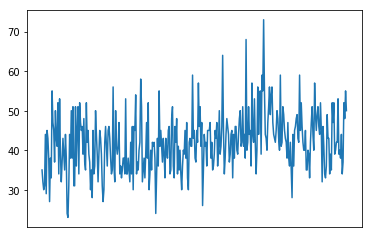

In [65]:
from matplotlib import pyplot
%matplotlib inline
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [68]:
# if __name__ == '__main__':
# define dataset
series = read_csv('data/daily-total-female-births.csv', header=0, index_col=0) 
data = series.values
# data split
n_test = 165
# model configs
max_length = len(data) - n_test
cfg_list = simple_configs(max_length)
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[1, 1, 'persist']] 8.722
 > Model[[2, 1, 'persist']] 9.284
 > Model[[2, 1, 'mean']] 7.884
 > Model[[3, 1, 'persist']] 9.320
 > Model[[3, 1, 'mean']] 7.518
 > Model[[23, 1, 'persist']] 9.759
 > Model[[3, 1, 'median']] 7.324
 > Model[[2, 1, 'median']] 7.884
 > Model[[23, 1, 'mean']] 6.932
 > Model[[4, 1, 'persist']] 9.249
 > Model[[42, 1, 'mean']] 7.098
 > Model[[4, 1, 'mean']] 7.290
 > Model[[61, 1, 'median']] 7.088
 > Model[[23, 1, 'median']] 7.096
 > Model[[24, 1, 'persist']] 10.065
 > Model[[62, 1, 'persist']] 10.374
 > Model[[24, 1, 'mean']] 6.952
 > Model[[42, 1, 'median']] 7.138
 > Model[[4, 1, 'median']] 7.217
 > Model[[43, 1, 'persist']] 9.659
 > Model[[5, 1, 'persist']] 9.415
 > Model[[5, 1, 'mean']] 7.204
 > Model[[62, 1, 'mean']] 7.138
 > Model[[43, 1, 'mean']] 7.087
 > Model[[24, 1, 'median']] 7.099
 > Model[[25, 1, 'persist']] 9.973
 > Model[[25, 1, 'mean']] 6.963
 > Model[[5, 1, 'median']] 7.337
 > Model[[43, 1, 'median']] 7.130
 > Model[[62, 1, 'median']] 7.068
 

 > Model[[102, 1, 'persist']] 10.198
 > Model[[84, 1, 'median']] 7.152
 > Model[[77, 1, 'median']] 7.148
 > Model[[85, 1, 'persist']] 10.452
 > Model[[61, 1, 'mean']] 7.130
 > Model[[78, 1, 'persist']] 10.221
 > Model[[102, 1, 'mean']] 7.292
 > Model[[85, 1, 'mean']] 7.237
 > Model[[78, 1, 'mean']] 7.203
 > Model[[119, 1, 'median']] 7.376
 > Model[[120, 1, 'persist']] 10.013
 > Model[[85, 1, 'median']] 7.157
 > Model[[120, 1, 'mean']] 7.350
 > Model[[86, 1, 'persist']] 10.627
 > Model[[78, 1, 'median']] 7.132
 > Model[[102, 1, 'median']] 7.274
 > Model[[79, 1, 'persist']] 10.741
 > Model[[103, 1, 'persist']] 10.024
 > Model[[79, 1, 'mean']] 7.213
 > Model[[86, 1, 'mean']] 7.243
 > Model[[103, 1, 'mean']] 7.291
 > Model[[120, 1, 'median']] 7.386
 > Model[[121, 1, 'persist']] 9.933
 > Model[[86, 1, 'median']] 7.176
 > Model[[87, 1, 'persist']] 10.571
 > Model[[79, 1, 'median']] 7.130
 > Model[[80, 1, 'persist']] 11.225
 > Model[[103, 1, 'median']] 7.285
 > Model[[87, 1, 'mean']] 7.247
 >

 > Model[[179, 1, 'median']] 7.669
 > Model[[180, 1, 'persist']] 11.156
 > Model[[163, 1, 'median']] 7.570
 > Model[[138, 1, 'median']] 7.451
 > Model[[164, 1, 'persist']] 10.966
 > Model[[154, 1, 'median']] 7.491
 > Model[[197, 1, 'persist']] 10.475
 > Model[[180, 1, 'mean']] 7.511
 > Model[[155, 1, 'persist']] 10.380
 > Model[[164, 1, 'mean']] 7.469
 > Model[[197, 1, 'mean']] 7.542
 > Model[[155, 1, 'mean']] 7.430
 > Model[[180, 1, 'median']] 7.656
 > Model[[181, 1, 'persist']] 10.707
 > Model[[164, 1, 'median']] 7.579
 > Model[[165, 1, 'persist']] 10.873
 > Model[[155, 1, 'median']] 7.492
 > Model[[156, 1, 'persist']] 10.690
 > Model[[197, 1, 'median']] 7.664
 > Model[[198, 1, 'persist']] 11.364
 > Model[[181, 1, 'mean']] 7.512
 > Model[[165, 1, 'mean']] 7.473
 > Model[[156, 1, 'mean']] 7.435
 > Model[[198, 1, 'mean']] 7.547
 > Model[[181, 1, 'median']] 7.651
 > Model[[182, 1, 'persist']] 10.871
 > Model[[165, 1, 'median']] 7.577
 > Model[[156, 1, 'median']] 7.506
 > Model[[166, 1, 

## 예제
- 3년간 샴푸 월별 세일 데이터
- 36개 데이터 중 24개를 훈련용으로 12개를 테스트용으로 사용
- 트렌드가 있는 경우

(36, 1)


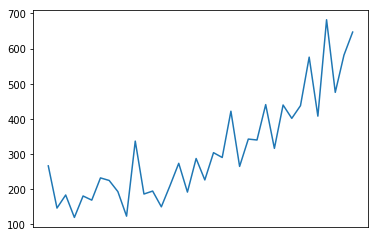

In [69]:
# load
series = read_csv('data/monthly-shampoo-sales.csv', header=0, index_col=0) 
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [73]:
# if __name__ == '__main__':
# load dataset
series = read_csv('data/monthly-shampoo-sales.csv', header=0, index_col=0) 
data = series.values
# data split
n_test = 12
# model configs
max_length = len(data) - n_test
cfg_list = simple_configs(max_length)
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[1, 1, 'persist']] 136.761
 > Model[[2, 1, 'mean']] 96.011
 > Model[[2, 1, 'persist']] 95.695
 > Model[[2, 1, 'median']] 96.011
 > Model[[3, 1, 'persist']] 123.969
 > Model[[3, 1, 'mean']] 96.403
 > Model[[3, 1, 'median']] 103.634
 > Model[[23, 1, 'median']] 221.863
 > Model[[24, 1, 'persist']] 305.635
 > Model[[4, 1, 'persist']] 136.813
 > Model[[4, 1, 'mean']] 100.609
 > Model[[24, 1, 'mean']] 213.466
 > Model[[4, 1, 'median']] 104.878
 > Model[[24, 1, 'median']] 226.061
 > Model[[5, 1, 'persist']] 127.656
 > Model[[5, 1, 'mean']] 101.862
 > Model[[5, 1, 'median']] 101.819
 > Model[[6, 1, 'persist']] 165.500
 > Model[[6, 1, 'mean']] 110.425
 > Model[[6, 1, 'median']] 114.959
 > Model[[7, 1, 'persist']] 164.514
 > Model[[7, 1, 'mean']] 115.500
 > Model[[7, 1, 'median']] 124.605
 > Model[[8, 1, 'persist']] 186.545
 > Model[[8, 1, 'mean']] 122.807
 > Model[[8, 1, 'median']] 132.409
 > Model[[9, 1, 'persist']] 193.951
 > Model[[9, 1, 'mean']] 128.902
 > Model[[9, 1, 'median']] 1

- 바로 앞의 샘플이 아니라, 두 단계 이전 값으로 예측하는 경우가 가장 성능이 좋았다.

## 예제
- 1920~1939 년 사이의 영국 노팅험 성의 월 평균 기온 데이터
- 계절적 요인이 강하게 나타난다,

(240, 1)


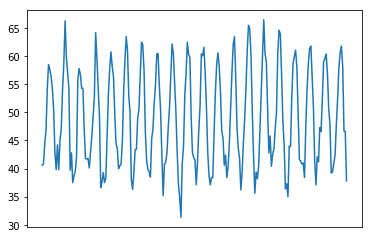

In [75]:
series = read_csv('data/monthly-mean-temp.csv', header=0, index_col=0) # summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [76]:
# trim dataset to 5 years
data = data[-(5*12):]

In [79]:
# if __name__ == '__main__':
# define dataset
series = read_csv('data/monthly-mean-temp.csv', header=0, index_col=0)
data = series.values
# data split
n_test = 12
  # model configs
max_length = len(data) - n_test
cfg_list = simple_configs(max_length, offsets=[1,12]) 
# grid search
scores = grid_search(data, cfg_list, n_test) 
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[1, 1, 'persist']] 5.143
 > Model[[1, 12, 'persist']] 5.143
 > Model[[2, 1, 'mean']] 6.538
 > Model[[2, 1, 'persist']] 8.492
 > Model[[2, 1, 'median']] 6.538
 > Model[[12, 1, 'median']] 8.001
 > Model[[22, 1, 'median']] 9.314
 > Model[[32, 1, 'median']] 9.299
 > Model[[2, 12, 'persist']] 8.492
 > Model[[12, 12, 'persist']] 2.195
 > Model[[22, 12, 'persist']] 8.835
 > Model[[32, 12, 'persist']] 14.023
 > Model[[12, 12, 'mean']] 1.651
 > Model[[2, 12, 'mean']] 1.589
 > Model[[23, 1, 'persist']] 5.363
 > Model[[33, 1, 'persist']] 11.291
 > Model[[12, 12, 'median']] 1.789
 > Model[[2, 12, 'median']] 1.589
 > Model[[13, 1, 'persist']] 5.074
 > Model[[33, 1, 'mean']] 8.797
 > Model[[23, 1, 'mean']] 8.615
 > Model[[3, 1, 'persist']] 12.006
 > Model[[13, 1, 'mean']] 7.878
 > Model[[23, 1, 'median']] 9.126
 > Model[[33, 1, 'median']] 9.445
 > Model[[3, 1, 'mean']] 8.155
 > Model[[23, 12, 'persist']] 5.363
 > Model[[33, 12, 'persist']] 11.291
 > Model[[13, 1, 'median']] 7.180
 > Model[[

 > Model[[65, 1, 'persist']] 17.958
 > Model[[73, 1, 'mean']] 8.143
 > Model[[57, 1, 'mean']] 8.589
 > Model[[65, 1, 'mean']] 8.261
 > Model[[44, 1, 'mean']] 8.746
 > Model[[57, 1, 'median']] 8.842
 > Model[[65, 1, 'median']] 8.355
 > Model[[73, 1, 'median']] 8.184
 > Model[[57, 12, 'persist']] 11.607
 > Model[[65, 12, 'persist']] 17.958
 > Model[[73, 12, 'persist']] 5.370
 > Model[[58, 1, 'persist']] 8.736
 > Model[[44, 1, 'median']] 9.015
 > Model[[74, 1, 'persist']] 9.318
 > Model[[66, 1, 'persist']] 18.333
 > Model[[74, 1, 'mean']] 8.082
 > Model[[58, 1, 'mean']] 8.512
 > Model[[66, 1, 'mean']] 8.408
 > Model[[44, 12, 'persist']] 15.531
 > Model[[45, 1, 'persist']] 13.168
 > Model[[58, 1, 'median']] 8.733
 > Model[[45, 1, 'mean']] 8.732
 > Model[[45, 1, 'median']] 8.993
 > Model[[74, 1, 'median']] 7.940
 > Model[[45, 12, 'persist']] 13.168
 > Model[[46, 1, 'persist']] 9.332
 > Model[[46, 1, 'mean']] 8.610
 > Model[[74, 12, 'persist']] 9.318
 > Model[[46, 1, 'median']] 8.800
 > Mode

 > Model[[91, 1, 'median']] 8.552
 > Model[[106, 12, 'persist']] 8.487
 > Model[[91, 12, 'persist']] 14.758
 > Model[[107, 1, 'persist']] 4.635
 > Model[[92, 1, 'persist']] 13.421
 > Model[[107, 1, 'mean']] 8.312
 > Model[[92, 1, 'mean']] 8.429
 > Model[[107, 1, 'median']] 8.395
 > Model[[122, 1, 'median']] 8.152
 > Model[[122, 12, 'persist']] 10.304
 > Model[[107, 12, 'persist']] 4.635
 > Model[[123, 1, 'persist']] 13.938
 > Model[[108, 1, 'persist']] 2.276
 > Model[[123, 1, 'mean']] 8.125
 > Model[[119, 1, 'mean']] 8.290
 > Model[[108, 1, 'mean']] 8.234
 > Model[[123, 1, 'median']] 8.145
 > Model[[123, 12, 'persist']] 13.938
 > Model[[108, 1, 'median']] 8.333
 > Model[[101, 1, 'median']] 8.357
 > Model[[108, 12, 'persist']] 2.276
 > Model[[124, 1, 'persist']] 16.004
 > Model[[119, 1, 'median']] 8.395
 > Model[[109, 1, 'persist']] 5.172
 > Model[[101, 12, 'persist']] 16.724
 > Model[[124, 1, 'mean']] 8.170
 > Model[[119, 12, 'persist']] 4.766
 > Model[[109, 1, 'mean']] 8.173
 > Model[

 > Model[[167, 1, 'mean']] 8.304
 > Model[[175, 1, 'persist']] 14.777
 > Model[[161, 1, 'mean']] 8.233
 > Model[[161, 1, 'median']] 8.342
 > Model[[167, 1, 'median']] 8.395
 > Model[[161, 12, 'persist']] 15.360
 > Model[[183, 1, 'mean']] 8.175
 > Model[[167, 12, 'persist']] 6.127
 > Model[[162, 1, 'persist']] 16.276
 > Model[[168, 1, 'persist']] 3.357
 > Model[[175, 1, 'mean']] 8.330
 > Model[[183, 1, 'median']] 8.145
 > Model[[162, 1, 'mean']] 8.280
 > Model[[183, 12, 'persist']] 12.263
 > Model[[168, 1, 'mean']] 8.252
 > Model[[192, 1, 'median']] 8.333
 > Model[[175, 1, 'median']] 8.676
 > Model[[192, 12, 'persist']] 3.945
 > Model[[168, 1, 'median']] 8.333
 > Model[[168, 12, 'persist']] 3.357
 > Model[[193, 1, 'persist']] 4.963
 > Model[[184, 1, 'persist']] 14.591
 > Model[[175, 12, 'persist']] 14.777
 > Model[[193, 1, 'mean']] 8.215
 > Model[[169, 1, 'persist']] 4.141
 > Model[[184, 1, 'mean']] 8.197
 > Model[[169, 1, 'mean']] 8.208
 > Model[[193, 1, 'median']] 8.276
 > Model[[176,

 > Model[[221, 1, 'mean']] 8.251
 > Model[[228, 1, 'mean']] 8.258
 > Model[[221, 1, 'median']] 8.445
 > Model[[221, 12, 'persist']] 15.171
 > Model[[228, 1, 'median']] 8.361
 > Model[[222, 1, 'persist']] 14.625
 > Model[[228, 12, 'persist']] 2.818
 > Model[[222, 1, 'mean']] 8.279
done
[4, 12, 'mean'] 1.5015616870445234
[8, 12, 'mean'] 1.5794579766489512
[13, 12, 'mean'] 1.586186052546763


## 예제
- 월별 자동차 판매 데이터 (퀘벡), 1960-1968
- 트렌드와 계절적 요인이 모두 존재

(108, 1)


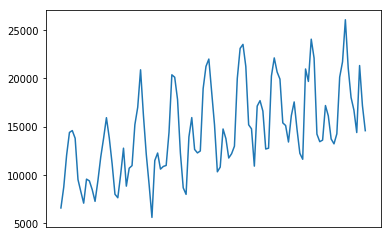

In [80]:
series = read_csv('data/monthly-car-sales.csv', header=0, index_col=0) 
# summarize shape
print(series.shape)
# plot
pyplot.plot(series)
pyplot.xticks([])
pyplot.show()

In [84]:
# if __name__ == '__main__':
# define dataset
series = read_csv('data/monthly-car-sales.csv', header=0, index_col=0) 
data = series.values
# data split
n_test = 12
# model configs
max_length = len(data) - n_test
cfg_list = simple_configs(max_length, offsets=[1,12])
# grid search
scores = grid_search(data, cfg_list, n_test) 
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[1, 1, 'persist']] 3783.966
 > Model[[2, 1, 'mean']] 4119.852
 > Model[[1, 12, 'persist']] 3783.966
 > Model[[2, 1, 'persist']] 5171.658
 > Model[[12, 1, 'persist']] 2290.827
 > Model[[2, 1, 'median']] 4119.852
 > Model[[21, 1, 'persist']] 6458.104
 > Model[[30, 1, 'median']] 4297.768
 > Model[[2, 12, 'persist']] 5171.658
 > Model[[12, 1, 'mean']] 3971.243
 > Model[[21, 1, 'mean']] 4222.612
 > Model[[30, 12, 'persist']] 5176.877
 > Model[[2, 12, 'mean']] 2215.186
 > Model[[12, 1, 'median']] 4734.762
 > Model[[21, 1, 'median']] 4667.979
 > Model[[31, 1, 'persist']] 5682.689
 > Model[[12, 12, 'persist']] 2290.827
 > Model[[2, 12, 'median']] 2215.186
 > Model[[21, 12, 'persist']] 6458.104
 > Model[[31, 1, 'mean']] 4017.619
 > Model[[13, 1, 'persist']] 4242.462
 > Model[[3, 1, 'persist']] 6000.907
 > Model[[22, 1, 'persist']] 5587.277
 > Model[[31, 1, 'median']] 4311.398
 > Model[[13, 1, 'mean']] 3842.464
 > Model[[3, 1, 'mean']] 4474.174
 > Model[[22, 1, 'mean']] 4217.423
 > Mode

 > Model[[53, 1, 'persist']] 6307.894
 > Model[[45, 1, 'mean']] 4185.410
 > Model[[62, 1, 'mean']] 4272.913
 > Model[[68, 1, 'median']] 5012.053
 > Model[[53, 1, 'mean']] 4117.670
 > Model[[45, 1, 'median']] 4678.661
 > Model[[68, 12, 'persist']] 9287.899
 > Model[[62, 1, 'median']] 4813.028
 > Model[[69, 1, 'persist']] 8779.493
 > Model[[45, 12, 'persist']] 7545.707
 > Model[[53, 1, 'median']] 4666.971
 > Model[[46, 1, 'persist']] 6501.924
 > Model[[62, 12, 'persist']] 7131.119
 > Model[[69, 1, 'mean']] 4546.075
 > Model[[53, 12, 'persist']] 6307.894
 > Model[[63, 1, 'persist']] 7734.524
 > Model[[46, 1, 'mean']] 4198.602
 > Model[[54, 1, 'persist']] 6630.561
 > Model[[63, 1, 'mean']] 4303.993
 > Model[[46, 1, 'median']] 4722.561
 > Model[[69, 1, 'median']] 5034.885
 > Model[[54, 1, 'mean']] 4131.595
 > Model[[63, 1, 'median']] 4847.713
 > Model[[46, 12, 'persist']] 6501.924
 > Model[[69, 12, 'persist']] 8779.493
 > Model[[63, 12, 'persist']] 7734.524
 > Model[[47, 1, 'persist']] 5026

# ETS  모델